In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error

In [2]:
# groud truth data 
df_items = pd.read_excel('capstone_data.xlsx', sheet_name='Items', index_col=0)
df_ratings = pd.read_excel('capstone_data.xlsx', sheet_name='Ratings', index_col=0)

# algorithms prediction 
df_cbf = pd.read_excel('capstone_data.xlsx', sheet_name='CBF', index_col=0)
df_itemsim = pd.read_excel('capstone_data.xlsx', sheet_name='Item-Item', index_col=0)
df_usersim = pd.read_excel('capstone_data.xlsx', sheet_name='User-User', index_col=0)
df_mf = pd.read_excel('capstone_data.xlsx', sheet_name='MF', index_col=0)
df_persbias = pd.read_excel('capstone_data.xlsx', sheet_name='PersBias', index_col=0)


In [3]:
# ensures all dataframes shares the same properties 
assert df_ratings.index.tolist() == df_cbf.index.tolist()
assert df_ratings.index.tolist() == df_itemsim.index.tolist()
assert df_ratings.index.tolist() == df_usersim.index.tolist()
assert df_ratings.index.tolist() == df_mf.index.tolist()
assert df_ratings.index.tolist() == df_persbias.index.tolist()

assert df_ratings.columns.tolist() == df_cbf.columns.tolist()
assert df_ratings.columns.tolist() == df_itemsim.columns.tolist()
assert df_ratings.columns.tolist() == df_usersim.columns.tolist()
assert df_ratings.columns.tolist() == df_mf.columns.tolist()
assert df_ratings.columns.tolist() == df_persbias.columns.tolist()

In [4]:
df_all_results = pd.concat([
    pd.Series(np.concatenate(df_ratings.values), name="ground_truth"),
    pd.Series(np.concatenate(df_cbf.values), name="cbf"),
    pd.Series(np.concatenate(df_itemsim.values), name="item_item"),
    pd.Series(np.concatenate(df_usersim.values), name="user_user"),
    pd.Series(np.concatenate(df_mf.values), name="mf"),
    pd.Series(np.concatenate(df_persbias.values), name="persbias")
], axis=1 ).dropna().reset_index(drop=True)

print('df_all_results.shape:', df_all_results.shape)

df_all_results.head()

df_all_results.shape: (1450, 6)


,ground_truth,cbf,item_item,user_user,mf,persbias
0,4.0,4.363733,4.519138,4.043067,4.324353,4.403725
1,5.0,4.901377,5.437919,5.239944,4.930692,5.013488
2,4.0,4.756129,4.192167,4.191001,5.045021,5.185511
3,5.0,5.137714,4.651734,4.762860,5.032640,5.134814
4,5.0,5.068848,5.061953,4.745852,4.927834,5.026830


Accuracy measurement

In [5]:
### accuracy metric: mean absolute error 

mae_cbf = mean_absolute_error(df_all_results['ground_truth'], df_all_results['cbf'])
mae_item_item = mean_absolute_error(df_all_results['ground_truth'], df_all_results['item_item'])
mae_user_user = mean_absolute_error(df_all_results['ground_truth'], df_all_results['user_user'])
mae_mf = mean_absolute_error(df_all_results['ground_truth'], df_all_results['mf'])
mae_persbias = mean_absolute_error(df_all_results['ground_truth'], df_all_results['persbias'])

print(f'Mean absolute error for Content-Based Filtering: {mae_cbf:.2f}')
print(f'Mean absolute error for Item-Item similarity: {mae_item_item:.2f}')
print(f'Mean absolute error for User-User similarity: {mae_user_user:.2f}')
print(f'Mean absolute error for Matrix Factorization: {mae_mf:.2f}')
print(f'Mean absolute error for Personalized Bias: {mae_persbias:.2f}')

Mean absolute error for Content-Based Filtering: 0.45
Mean absolute error for Item-Item similarity: 0.43
Mean absolute error for User-User similarity: 0.40
Mean absolute error for Matrix Factorization: 0.53
Mean absolute error for Personalized Bias: 0.53


Rank measurements

In [6]:
def get_top_k(df_ratings_matrix: pd.DataFrame, k=5):
    """ 
    froms the ratings matrix, extract the top k recommendations for each user 
    """
    df_ratings_matrix.index.name = df_ratings_matrix.index.name.lower()
    df = df_ratings_matrix.reset_index().melt(
        id_vars='item').rename(columns={'variable': 'user', 'value': 'rating'})
    
    df = df.dropna().sort_values('rating', ascending=False
        ).set_index(['item', 'user'])['rating']
    
    if k > 0: 
        return df.groupby('user').head(5)
    return df

In [7]:
get_top_k(df_ratings)

item  user
1531  1348    5.0
1326  1112    5.0
1804  993     5.0
1945  993     5.0
2063  993     5.0
             ... 
1790  1716    4.0
133   1862    4.0
670   1862    4.0
1481  1862    4.0
1745  1862    4.0
Name: rating, Length: 500, dtype: float64

In [8]:
top_cbf = get_top_k(df_cbf, k=5)
top_item_item = get_top_k(df_itemsim, k=5)
top_user_user = get_top_k(df_usersim, k=5)
top_mf = get_top_k(df_mf, k=5)
top_persbias = get_top_k(df_persbias, k=5)


In [9]:
df_ratings_long = get_top_k(df_ratings, 0)

print('df_ratings_long.shape:', df_ratings_long.shape)
df_ratings_long.head()

df_ratings_long.shape: (1462,)


item  user
1531  1348    5.0
1326  1112    5.0
1804  993     5.0
1945  993     5.0
2063  993     5.0
Name: rating, dtype: float64

In [ ]:
# number of users with a matching recommendation
matching_top_cbf = pd.concat([df_ratings_long, top_cbf], axis=1).dropna(subset='rating')
matching_top_item_item = pd.concat([df_ratings_long, top_item_item], axis=1).dropna(subset='rating')
matching_top_user_user = pd.concat([df_ratings_long, top_user_user], axis=1).dropna(subset='rating')
matching_top_mf = pd.concat([df_ratings_long, top_mf], axis=1).dropna(subset='rating')
matching_top_persbias = pd.concat([df_ratings_long, top_cbf], axis=1).dropna(subset='rating')



In [11]:
acc_top5_cbf = matching_top_cbf.index.get_level_values(1).nunique() / len(df_ratings.columns)
acc_top5_item_item = matching_top_item_item.index.get_level_values(1).nunique()  / len(df_ratings.columns)
acc_top5_user_user = matching_top_user_user.index.get_level_values(1).nunique()  / len(df_ratings.columns)
acc_top5_mf = matching_top_mf.index.get_level_values(1).nunique()  / len(df_ratings.columns)
acc_top5_persbias = matching_top_persbias.index.get_level_values(1).nunique()  / len(df_ratings.columns)


In [12]:
print(f'Accuracy @ top 5 for Content-Based Filtering: {acc_top5_cbf}')
print(f'Accuracy @ top 5 for Item-Item similarity: {acc_top5_item_item}')
print(f'Accuracy @ top 5 for User-User similarity: {acc_top5_user_user}')
print(f'Accuracy @ top 5 for Matrix Factorization: {acc_top5_mf}')
print(f'Accuracy @ top 5 for Personalized Bias: {acc_top5_persbias}')

Accuracy @ top 5 for Content-Based Filtering: 0.4
Accuracy @ top 5 for Item-Item similarity: 0.65
Accuracy @ top 5 for User-User similarity: 0.96
Accuracy @ top 5 for Matrix Factorization: 0.3
Accuracy @ top 5 for Personalized Bias: 0.4


Diversity

In [13]:
df_diversity_stats = pd.concat([
    top_cbf.reset_index(level=1).join(df_items
        ).groupby(['user'])['LeafCat'].nunique(
            ).agg(['mean', 'median', 'min']),
    top_item_item.reset_index(level=1).join(df_items
        ).groupby(['user'])['LeafCat'].nunique(
            ).agg(['mean', 'median', 'min']),
    top_user_user.reset_index(level=1).join(df_items
        ).groupby(['user'])['LeafCat'].nunique(
            ).agg(['mean', 'median', 'min']),
    top_mf.reset_index(level=1).join(df_items
        ).groupby(['user'])['LeafCat'].nunique(
            ).agg(['mean', 'median', 'min']),
    top_persbias.reset_index(level=1).join(df_items
        ).groupby(['user'])['LeafCat'].nunique(
            ).agg(['mean', 'median', 'min']),
], axis=1)

df_diversity_stats.columns = ['cbf', 'item_item', 'user_user', 'mf', 'persbias']
df_diversity_stats

,cbf,item_item,user_user,mf,persbias
mean,4.4,4.76,4.737374,4.98,4.0
median,5.0,5.00,5.000000,5.00,4.0
min,1.0,2.00,3.000000,4.00,4.0


In [14]:
print(f'Unique values for top_cbf:', top_cbf.reset_index(level=1).index.nunique())
print(f'Unique values for top_item_item:', top_item_item.reset_index(level=1).index.nunique())
print(f'Unique values for top_user_user:', top_user_user.reset_index(level=1).index.nunique())
print(f'Unique values for top_mf:', top_mf.reset_index(level=1).index.nunique())
print(f'Unique values for top_persbias:', top_persbias.reset_index(level=1).index.nunique())

Unique values for top_cbf: 41
Unique values for top_item_item: 106
Unique values for top_user_user: 150
Unique values for top_mf: 9
Unique values for top_persbias: 5


Diversity accross Price

<Axes: >

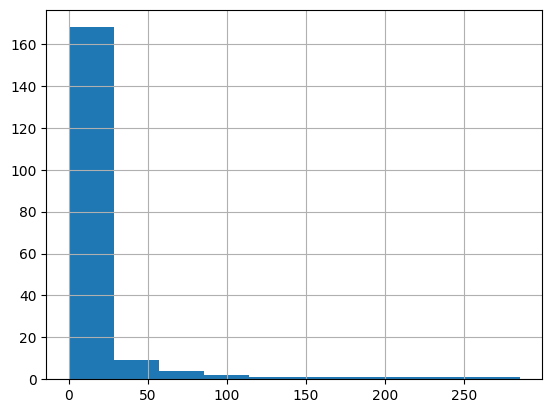

In [15]:
df_items.Price.hist()

In [16]:
df_items['price_bucket'] = pd.qcut(df_items.Price, 4)

In [17]:
df_diversity_stats_price = pd.concat([
    top_cbf.reset_index(level=1).join(df_items
        ).groupby(['user'])['price_bucket'].nunique(
            ).agg(['mean', 'median', 'min']),
    top_item_item.reset_index(level=1).join(df_items
        ).groupby(['user'])['price_bucket'].nunique(
            ).agg(['mean', 'median', 'min']),
    top_user_user.reset_index(level=1).join(df_items
        ).groupby(['user'])['price_bucket'].nunique(
            ).agg(['mean', 'median', 'min']),
    top_mf.reset_index(level=1).join(df_items
        ).groupby(['user'])['price_bucket'].nunique(
            ).agg(['mean', 'median', 'min']),
    top_persbias.reset_index(level=1).join(df_items
        ).groupby(['user'])['price_bucket'].nunique(
            ).agg(['mean', 'median', 'min']),
], axis=1)

df_diversity_stats_price.columns = ['cbf', 'item_item', 'user_user', 'mf', 'persbias']
df_diversity_stats_price

,cbf,item_item,user_user,mf,persbias
mean,3.27,3.01,2.949495,3.02,4.0
median,3.00,3.00,3.000000,3.00,4.0
min,2.00,1.00,1.000000,3.00,4.0


Serendipity

In [90]:
# most popular items 
most_popular_items = df_ratings.notnull().sum(axis=1).sort_values(ascending=False).head(50).index.tolist()

In [91]:
def calculate_serendipity(df_ratings_matrix: pd.DataFrame, popular_items: list[str], k: int = 5): 
    df = get_top_k(df_ratings_matrix, k=k)
    items_recommended = df.index.get_level_values(0).tolist()
    serendipitous = sum([1 for i in items_recommended if i not in popular_items])

    return serendipitous / len(items_recommended)

In [ ]:
serendipity_cbf = calculate_serendipity(df_cbf, most_popular_items)
serendipity_item_item = calculate_serendipity(df_itemsim, most_popular_items)
serendipity_user_user = calculate_serendipity(df_usersim, most_popular_items)
serendipity_mf = calculate_serendipity(df_mf, most_popular_items)
serendipity_persbias = calculate_serendipity(df_cbf, most_popular_items)

In [21]:
print(f'Serendipity for top_cbf:', serendipity_cbf)
print(f'Serendipity for serendipity_item_item:', serendipity_item_item)
print(f'Serendipity for serendipity_user_user:', serendipity_user_user)
print(f'Serendipity for serendipity_mf:', serendipity_mf)
print(f'Serendipity for serendipity_persbias:', serendipity_persbias)

Serendipity for top_cbf: 0.91
Serendipity for serendipity_item_item: 0.804
Serendipity for serendipity_user_user: 0.6484848484848484
Serendipity for serendipity_mf: 0.906
Serendipity for serendipity_persbias: 0.91


### Final table

In [38]:
df_summary = pd.concat([
    pd.Series([
        mae_cbf,
        acc_top5_cbf,
        top_cbf.reset_index(level=1).index.nunique(),
        df_diversity_stats_price.loc['mean', 'cbf'],
        serendipity_cbf
    ]).rename('CBF'),
    pd.Series([
        mae_item_item,
        acc_top5_item_item,
        top_item_item.reset_index(level=1).index.nunique(),
        df_diversity_stats_price.loc['mean', 'item_item'],
        serendipity_item_item
    ]).rename('Item-item'),
    pd.Series([
        mae_user_user,
        acc_top5_user_user,
        top_user_user.reset_index(level=1).index.nunique(),
        df_diversity_stats_price.loc['mean', 'user_user'],
        serendipity_user_user
    ]).rename('User-User'),
    pd.Series([
        mae_mf,
        acc_top5_mf,
        top_mf.reset_index(level=1).index.nunique(),
        df_diversity_stats_price.loc['mean', 'mf'],
        serendipity_mf
    ]).rename('Matrix Factorization'),
    pd.Series([
        mae_persbias,
        acc_top5_persbias,
        top_persbias.reset_index(level=1).index.nunique(),
        df_diversity_stats_price.loc['mean', 'persbias'],
        serendipity_persbias
    ]).rename('PersBias')
    
], axis=1)


df_summary.index = ['mae', 'accuracy @ 5', 'diversity (categories)', 'diversity (price)', 'serendipity']

In [39]:
df_summary

,CBF,Item-item,User-User,Matrix Factorization,PersBias
mae,0.453915,0.433561,0.403856,0.533153,0.533892
accuracy @ 5,0.400000,0.650000,0.960000,0.300000,0.400000
diversity (categories),41.000000,106.000000,150.000000,9.000000,5.000000
diversity (price),3.270000,3.010000,2.949495,3.020000,4.000000
serendipity,0.910000,0.804000,0.648485,0.906000,0.910000


### Part 3 - Hybridizing

Multiple weightings of the models User collaborative filter, matrix factorization and content based

In [215]:
import itertools

models = ['cbf', 'mf', 'user_user', 'item_item', 'persbias']

model_outputs = {
    "cbf": df_cbf,
    "mf": df_mf,
    "user_user": df_usersim,
    "item_item": df_itemsim,
    "persbias": df_persbias
}

experiment_results = []


for model_a, model_b in itertools.combinations(models, 2): 
    df_a = model_outputs[model_a]
    df_b = model_outputs[model_b]

    for i in range(1, 10):
        frac_a = round(i / 10, 1)
        new_preds = df_a * frac_a + df_b * (1 - frac_a)

        # dictionary to hold results
        experiment_run = {
            "model_a": model_a,
            "model_b": model_b,
            "weight_a": frac_a,
            "weight_b": 1 - frac_a,
        }

        # mae
        vals_experiment = pd.concat([
            pd.Series(np.concatenate(df_ratings.values), name="ground_truth"),
            pd.Series(np.concatenate(new_preds.values), name="pred")
        ], axis=1 ).dropna().reset_index(drop=True)

        mae = mean_absolute_error(vals_experiment.ground_truth, vals_experiment.pred)

        experiment_run["mae"] = mae


        # precision at k5
        top_exp = get_top_k(new_preds)
        matching_top_exp = pd.concat([df_ratings_long, top_exp], axis=1).dropna(subset='rating')
        acc_top5_exp = matching_top_exp.index.get_level_values(1).nunique() / len(df_ratings.columns)

        experiment_run["precision_at_5"] = acc_top5_exp


        # diversity in products
        experiment_run["diversity"] = top_exp.reset_index(level=1).index.nunique()

        # serendipity 
        experiment_run["serendipity"] = calculate_serendipity(new_preds, most_popular_items)


        experiment_results.append(experiment_run)


In [216]:
df_experiment_results = pd.DataFrame(experiment_results).sort_values(by='precision_at_5', ascending=False)
df_experiment_results.head(20)

,model_a,model_b,weight_a,weight_b,mae,precision_at_5,diversity,serendipity
10,cbf,user_user,0.2,0.8,0.386091,0.99,126,0.602020
9,cbf,user_user,0.1,0.9,0.393586,0.97,138,0.616162
71,user_user,item_item,0.9,0.1,0.389680,0.97,142,0.638384
36,mf,user_user,0.1,0.9,0.396547,0.96,139,0.622222
80,user_user,persbias,0.9,0.1,0.396974,0.96,137,0.622222
79,user_user,persbias,0.8,0.2,0.394509,0.96,123,0.618182
70,user_user,item_item,0.8,0.2,0.379212,0.96,141,0.646465
37,mf,user_user,0.2,0.8,0.393916,0.95,125,0.616162
11,cbf,user_user,0.3,0.7,0.381860,0.95,112,0.610101
69,user_user,item_item,0.7,0.3,0.372054,0.95,127,0.664646


In [217]:
df_experiment_results[df_experiment_results.precision_at_5 > .9].sort_values(by='mae', ascending=True)

,model_a,model_b,weight_a,weight_b,mae,precision_at_5,diversity,serendipity
68,user_user,item_item,0.6,0.4,0.368948,0.91,116,0.694949
69,user_user,item_item,0.7,0.3,0.372054,0.95,127,0.664646
70,user_user,item_item,0.8,0.2,0.379212,0.96,141,0.646465
12,cbf,user_user,0.4,0.6,0.380980,0.93,96,0.614141
11,cbf,user_user,0.3,0.7,0.381860,0.95,112,0.610101
10,cbf,user_user,0.2,0.8,0.386091,0.99,126,0.602020
71,user_user,item_item,0.9,0.1,0.389680,0.97,142,0.638384
9,cbf,user_user,0.1,0.9,0.393586,0.97,138,0.616162
37,mf,user_user,0.2,0.8,0.393916,0.95,125,0.616162
79,user_user,persbias,0.8,0.2,0.394509,0.96,123,0.618182


In [218]:
# best model = 70% user_user / 30% item_item

best_pred = df_usersim * .7 + df_itemsim * .3

In [254]:
# efficiently get the top 5 recommendations for each user 

def get_recommenations_for_user(df_ratings_matrix, n = 5): 

    df_ratings_matrix = df_ratings_matrix.T
    ratings_arr = df_ratings_matrix.values

    # get the top n indices for each row
    top_indices = np.argpartition(-ratings_arr, n, axis=1)[:, :n]
    # get the order of each top index (0 to n-1)
    top_indices_order = np.argsort(-ratings_arr[np.arange(ratings_arr.shape[0])[:, None], top_indices])
    # apply the order to the indices to sort them
    top_indices_sorted = top_indices[np.arange(top_indices.shape[0])[:, None], top_indices_order]

    # mp sorted indices back to item names
    top_n_items = df_ratings_matrix.columns.to_numpy()[top_indices_sorted]

    return pd.DataFrame(
        top_n_items,
        index = df_ratings_matrix.index,
        columns = [f"Top {i+1}" for i in range(n)]
    )

In [270]:
get_recommenations_for_user(best_pred)

,Top 1,Top 2,Top 3,Top 4,Top 5
64,1518,2257,1032,1951,1317
65,45,1461,619,1763,1377
75,2080,327,1806,2101,2169
79,1798,1297,45,619,1245
83,327,2169,1379,1136,1297
...,...,...,...,...,...
3902,1296,2247,2257,1763,1297
3991,41,256,779,1764,619
4047,1245,1240,2247,1763,1455
4342,257,1328,1319,2063,619


In [267]:
# comparing recommendations for hybrid model 
pd.concat([
    get_recommenations_for_user(df_usersim, 5),
    get_recommenations_for_user(df_cbf, 5),
    get_recommenations_for_user(best_pred, 5)
], keys= ['user_user', 'cbf', 'hybrid']).reset_index().set_index('level_1').loc[['64', '65', '75']]#.to_clipboard()

,level_0,Top 1,Top 2,Top 3,Top 4,Top 5
level_1,,,,,,
64,user_user,1518,1317,1951,1790,1240
64,cbf,1874,1387,2257,1951,327
64,hybrid,1518,2257,1032,1951,1317
65,user_user,45,1763,619,2068,1461
65,cbf,2257,1032,1874,327,2247
65,hybrid,45,1461,619,1763,1377
75,user_user,2080,1806,2258,327,2233
75,cbf,2257,1874,1387,327,2247
75,hybrid,2080,327,1806,2101,2169
